<a href="https://colab.research.google.com/github/chuchun2/ATMS-597-Project-4-Group-C/blob/edit_chuchun/Project4_0407_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

### Import Libraries and mount drive

In [0]:
import tarfile
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

In [330]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<b>Set Your Directory</b>

In [0]:
# YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project4/' #Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS 597/P04/' #Cathy
YOUR_DIRECTORY = '/content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 4/Project 4/' #Chu-Chun

### <b>Import</b> GFS data - Daily

In [0]:
# daily = tarfile.open(name = YOUR_DIRECTORY + 'daily.tar.gz') # Set the archive for opening

# # Aggregate to PD DataFrame
# cur_file = daily.next() # Initiate while loop using the first file in the tar archive
# daily_gfs_raw = pd.DataFrame(columns=['TMAX', 'TMIN', 'WMAX', 'RTOT']) # 'RTOT' is precip
# i = 0
# while cur_file != None:
#     i += 1
#     if i % 350 == 0:
#         print(float(i/3500))
#     working_file = YOUR_DIRECTORY + cur_file.name
#     daily.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
#     convert_to_df = pd.read_csv(working_file, index_col=0, parse_dates=True, 
#                                 infer_datetime_format=True) # Convert cur_file 
#                                 # (TarInfo Object) to string, then to PD; convert
#                                 # index col to DateTime
#     daily_gfs_raw = daily_gfs_raw.append(convert_to_df) # Append PD to DF
#     os.remove(working_file) # Remove file extracted in directory
#     cur_file = daily.next() # Go to next file in archive

# daily.close() # Close .tar

# daily_gfs_raw.to_csv(YOUR_DIRECTORY + 'daily_gfs_raw.csv')
# daily_gfs_raw

In [333]:
# Read the saved file
daily_gfs_raw = pd.read_csv(YOUR_DIRECTORY + 'daily_gfs_raw.csv', index_col=0)
daily_gfs_raw.index = pd.to_datetime(daily_gfs_raw.index)
daily_gfs_raw

,TMAX,TMIN,WMAX,RTOT
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77
...,...,...,...,...
2020-01-27 12:00:00,0.84,-1.26,1.984943,0.29
2020-01-28 12:00:00,1.44,-2.56,2.319483,0.57
2020-01-29 12:00:00,2.34,-2.46,1.802776,0.00
2020-01-30 12:00:00,2.84,-1.06,2.121320,1.13


In [334]:
# Find missing dates
missing_daily_gfs = pd.date_range(start = '2010-01-01 12:00:00', 
                                  end = '2020-01-31 12:00:00', 
                                  freq='D').difference(daily_gfs_raw.index)
missing_daily_gfs

DatetimeIndex(['2010-06-20 12:00:00', '2013-08-16 12:00:00',
               '2013-08-17 12:00:00', '2013-08-18 12:00:00',
               '2014-04-05 12:00:00', '2014-05-03 12:00:00',
               '2014-05-04 12:00:00', '2014-05-05 12:00:00',
               '2014-05-06 12:00:00', '2014-05-07 12:00:00',
               '2014-05-08 12:00:00', '2014-05-09 12:00:00',
               '2014-05-10 12:00:00', '2014-05-11 12:00:00',
               '2014-10-11 12:00:00', '2014-12-19 12:00:00',
               '2015-04-18 12:00:00', '2015-06-23 12:00:00',
               '2015-10-10 12:00:00', '2016-04-09 12:00:00',
               '2016-04-10 12:00:00', '2017-04-15 12:00:00',
               '2017-07-19 12:00:00', '2017-07-20 12:00:00',
               '2017-07-21 12:00:00', '2017-07-22 12:00:00',
               '2017-07-23 12:00:00', '2017-07-24 12:00:00',
               '2017-07-25 12:00:00', '2017-07-26 12:00:00',
               '2017-07-27 12:00:00', '2017-07-28 12:00:00',
               '2017-07-

In [335]:
# Change index from model initial time to forecast valid time
daily_gfs_valid_time = daily_gfs_raw
daily_gfs_valid_time.index = daily_gfs_valid_time.index + pd.Timedelta('18H')
daily_gfs_valid_time

,TMAX,TMIN,WMAX,RTOT
2010-01-02 06:00:00,-11.26,-16.46,7.323933,0.05
2010-01-03 06:00:00,-10.16,-15.96,4.687217,0.00
2010-01-04 06:00:00,-9.96,-14.36,5.941380,0.06
2010-01-05 06:00:00,-8.46,-12.86,5.685068,0.17
2010-01-06 06:00:00,-7.16,-11.06,3.794733,0.77
...,...,...,...,...
2020-01-28 06:00:00,0.84,-1.26,1.984943,0.29
2020-01-29 06:00:00,1.44,-2.56,2.319483,0.57
2020-01-30 06:00:00,2.34,-2.46,1.802776,0.00
2020-01-31 06:00:00,2.84,-1.06,2.121320,1.13


### <b>Import</b> GFS data - Profiles

In [0]:
# # Profile gfs data
# prof = tarfile.open(name = YOUR_DIRECTORY + 'prof.tar.gz') # Set the archive for opening

# # Aggregate to PD DataFrame
# cur_file = prof.next() # Initiate while loop using the first file in the tar archive
# prof_gfs_raw = pd.DataFrame(columns=['DWPC','HGHT','PRES','TMPC','UWND','VWND'])
# i = 0
# while cur_file != None:
#     i += 1
#     if i % 350 == 0:
#         print(float(i/3500))
#     working_file = YOUR_DIRECTORY + cur_file.name
#     prof.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
#     convert_to_df = pd.read_csv(working_file, index_col=0, parse_dates=True, 
#                                 infer_datetime_format=True) # Convert cur_file 
#                                 # (TarInfo Object) to string, then to PD; convert
#                                 # index col to DateTime
#     prof_gfs_raw = prof_gfs_raw.append(convert_to_df) # Append PD to DF
#     os.remove(working_file) # Remove file extracted in directory
#     cur_file = prof.next() # Go to next file in archive

# prof.close() # Close .tar

# prof_gfs_raw.to_csv(YOUR_DIRECTORY + 'prof_gfs_raw.csv')
# prof_gfs_raw

In [337]:
# Read the saved file
prof_gfs_raw = pd.read_csv(YOUR_DIRECTORY + 'prof_gfs_raw.csv', index_col=0)
prof_gfs_raw.index = pd.to_datetime(prof_gfs_raw.index)
prof_gfs_raw

,DWPC,HGHT,PRES,TMPC,UWND,VWND
2010-01-02 06:00:00,"[-17.885416666666668, -22.15150234741784, -38....","[822.2693055555555, 1460.1033333333335, 2904.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-16.249583333333334, -16.52291079812207, -21....","[10.566530573750587, 4.214706046596407, 17.668...","[-21.60349159268254, -18.30022411700173, -29.5..."
2010-01-02 09:00:00,"[-19.453124999999996, -24.9388679245283, -42.0...","[822.0543749999998, 1459.7785849056602, 2907.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-17.247500000000002, -16.19490566037736, -20....","[13.681992680084207, 9.948942540840713, 19.953...","[-21.05132415236028, -17.798267800386434, -29...."
2010-01-02 12:00:00,"[-24.917708333333334, -29.536603773584904, -42...","[820.327638888889, 1459.582075471698, 2915.667...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-15.991249999999997, -15.280283018867925, -19...","[12.509088069631126, 14.999567192631927, 23.33...","[-25.372665670766228, -22.851012927878898, -32..."
2010-01-02 15:00:00,"[-29.030482758620682, -37.651971830985914, -43...","[826.2597241379308, 1463.5210798122066, 2927.6...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-18.595172413793104, -14.76, -16.487358490566...","[11.080763032604898, 13.737749044170894, 22.27...","[-20.65371472040801, -25.032875351390114, -38...."
2010-01-02 18:00:00,"[-24.84875862068967, -32.677452830188685, -41....","[823.4282758620693, 1458.4197169811318, 2927.1...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-19.58413793103448, -15.190188679245283, -15....","[11.173738737104433, 11.725204010079779, 25.07...","[-14.419104627678692, -22.850212323925128, -37..."
...,...,...,...,...,...,...
2020-02-01 18:00:00,"[-2.420708661417323, -9.530575916230358, -24.0...","[742.415748031496, 1411.5072251308898, 2941.86...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.2914960629921257, -2.228062827225135, -8.0...","[19.811216208528656, 21.260362044096723, 30.08...","[1.3604678475628496, -12.77327158763928, -28.9..."
2020-02-01 21:00:00,"[-2.7182608695652157, -14.782617801047117, -18...","[728.3838260869561, 1400.3076963350782, 2936.0...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.0765217391304316, -0.4961256544502628, -7....","[23.064567282086532, 29.518982185029717, 36.16...","[0.7999300627093688, -17.180421782239765, -26...."
2020-02-02 00:00:00,"[-2.8084210526315774, -24.81340314136124, -15....","[732.0842105263156, 1408.2601570680624, 2948.3...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.6178947368421035, 1.2138219895287963, -6.8...","[25.1585312681121, 28.268556591902666, 33.6927...","[-1.6826343774112273, -18.266906968792057, -26..."
2020-02-02 03:00:00,"[-2.5436842105263135, -20.719368421052636, -8....","[728.0584210526313, 1410.5297894736839, 2954.7...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-0.5178947368421041, 2.6589473684210545, -5.6...","[28.84389310205612, 26.622661595180148, 31.722...","[-1.9461498953626104, -9.480785181647251, -23...."


In [338]:
# Find missing times
missing_prof_gfs = pd.date_range(start = '2010-01-02 06:00:00', 
                                 end = '2020-02-02 06:00:00', 
                                 freq='3H').difference(prof_gfs_raw.index)
missing_prof_gfs

DatetimeIndex(['2010-06-21 09:00:00', '2010-06-21 12:00:00',
               '2010-06-21 15:00:00', '2010-06-21 18:00:00',
               '2010-06-21 21:00:00', '2010-06-22 00:00:00',
               '2010-06-22 03:00:00', '2013-08-17 09:00:00',
               '2013-08-17 12:00:00', '2013-08-17 15:00:00',
               ...
               '2018-05-13 21:00:00', '2018-05-14 00:00:00',
               '2018-05-14 03:00:00', '2019-04-14 09:00:00',
               '2019-04-14 12:00:00', '2019-04-14 15:00:00',
               '2019-04-14 18:00:00', '2019-04-14 21:00:00',
               '2019-04-15 00:00:00', '2019-04-15 03:00:00'],
              dtype='datetime64[ns]', length=289, freq=None)

In [339]:
# Example of extract certain pressure level in GFS profile data
type(prof_gfs_raw['DWPC'][0])  # string
type(prof_gfs_raw['DWPC'][0].strip('][').split(', '))  # converted from string to list
# [float((prof_gfs_raw['DWPC'][i].strip('][').split(', '))[0])  for i in range(0,len(prof_gfs_raw['DWPC']))]  # read the first element of each sublist
[float((i.strip('][').split(', '))[0]) for i in prof_gfs_raw['DWPC']]  # read the first element of each sublist

[-17.885416666666668,
 -19.453124999999996,
 -24.917708333333334,
 -29.030482758620682,
 -24.84875862068967,
 -23.723541666666648,
 -27.292965517241385,
 -27.28510344827586,
 -25.6275,
 -27.400208333333335,
 -25.32289655172414,
 -24.126206896551725,
 -23.56931034482759,
 -21.798275862068966,
 -22.262758620689652,
 -26.025517241379312,
 -28.16722222222222,
 -25.736666666666657,
 -19.079166666666666,
 -19.59786206896552,
 -20.26253846153846,
 -21.559076923076926,
 -19.775230769230774,
 -17.457441860465117,
 -17.07441860465116,
 -16.72186046511628,
 -15.979302325581395,
 -16.81519379844961,
 -15.397906976744185,
 -14.63046511627907,
 -14.680697674418603,
 -14.983023255813954,
 -14.557441860465117,
 -15.093488372093022,
 -16.711461538461535,
 -18.422790697674422,
 -12.921860465116279,
 -13.37093023255814,
 -14.35565891472868,
 -16.12186046511628,
 -16.882325581395346,
 -17.544531249999995,
 -17.592635658914727,
 -17.359534883720933,
 -12.294186046511628,
 -11.25093023255814,
 -10.774140625

In [340]:
prof_gfs_raw['UWND_925'] = [float((i.strip('][').split(', '))[0]) for i in prof_gfs_raw['UWND']]
prof_gfs_raw['UWND_850'] = [float((i.strip('][').split(', '))[1]) for i in prof_gfs_raw['UWND']]
prof_gfs_raw['UWND_700'] = [float((i.strip('][').split(', '))[2]) for i in prof_gfs_raw['UWND']] 
prof_gfs_raw['UWND_500'] = [float((i.strip('][').split(', '))[3]) for i in prof_gfs_raw['UWND']]
prof_gfs_raw['UWND_250'] = [float((i.strip('][').split(', '))[4]) for i in prof_gfs_raw['UWND']]
prof_gfs_raw['UWND_100'] = [float((i.strip('][').split(', '))[5]) for i in prof_gfs_raw['UWND']]

prof_gfs_raw['VWND_925'] = [float((i.strip('][').split(', '))[0]) for i in prof_gfs_raw['VWND']]
prof_gfs_raw['VWND_850'] = [float((i.strip('][').split(', '))[1]) for i in prof_gfs_raw['VWND']]
prof_gfs_raw['VWND_700'] = [float((i.strip('][').split(', '))[2]) for i in prof_gfs_raw['VWND']] 
prof_gfs_raw['VWND_500'] = [float((i.strip('][').split(', '))[3]) for i in prof_gfs_raw['VWND']]
prof_gfs_raw['VWND_250'] = [float((i.strip('][').split(', '))[4]) for i in prof_gfs_raw['VWND']]
prof_gfs_raw['VWND_100'] = [float((i.strip('][').split(', '))[5]) for i in prof_gfs_raw['VWND']]

prof_gfs_raw['DWPC_925'] = [float((i.strip('][').split(', '))[0]) for i in prof_gfs_raw['DWPC']]
prof_gfs_raw['DWPC_850'] = [float((i.strip('][').split(', '))[1]) for i in prof_gfs_raw['DWPC']]
prof_gfs_raw['DWPC_700'] = [float((i.strip('][').split(', '))[2]) for i in prof_gfs_raw['DWPC']] 
prof_gfs_raw['DWPC_500'] = [float((i.strip('][').split(', '))[3]) for i in prof_gfs_raw['DWPC']]
prof_gfs_raw['DWPC_250'] = [float((i.strip('][').split(', '))[4]) for i in prof_gfs_raw['DWPC']]
prof_gfs_raw['DWPC_100'] = [float((i.strip('][').split(', '))[5]) for i in prof_gfs_raw['DWPC']]

prof_gfs_raw

,DWPC,HGHT,PRES,TMPC,UWND,VWND,UWND_925,UWND_850,UWND_700,UWND_500,UWND_250,UWND_100,VWND_925,VWND_850,VWND_700,VWND_500,VWND_250,VWND_100,DWPC_925,DWPC_850,DWPC_700,DWPC_500,DWPC_250,DWPC_100
2010-01-02 06:00:00,"[-17.885416666666668, -22.15150234741784, -38....","[822.2693055555555, 1460.1033333333335, 2904.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-16.249583333333334, -16.52291079812207, -21....","[10.566530573750587, 4.214706046596407, 17.668...","[-21.60349159268254, -18.30022411700173, -29.5...",10.566531,4.214706,17.668810,51.474499,80.039564,58.267854,-21.603492,-18.300224,-29.544206,-49.513732,-58.904689,-24.295145,-17.885417,-22.151502,-38.936782,-58.098371,-71.388427,NaN
2010-01-02 09:00:00,"[-19.453124999999996, -24.9388679245283, -42.0...","[822.0543749999998, 1459.7785849056602, 2907.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-17.247500000000002, -16.19490566037736, -20....","[13.681992680084207, 9.948942540840713, 19.953...","[-21.05132415236028, -17.798267800386434, -29....",13.681993,9.948943,19.953202,54.090614,85.232987,60.914596,-21.051324,-17.798268,-29.894744,-60.208588,-61.580632,-28.177464,-19.453125,-24.938868,-42.044969,-58.101408,-71.386866,NaN
2010-01-02 12:00:00,"[-24.917708333333334, -29.536603773584904, -42...","[820.327638888889, 1459.582075471698, 2915.667...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-15.991249999999997, -15.280283018867925, -19...","[12.509088069631126, 14.999567192631927, 23.33...","[-25.372665670766228, -22.851012927878898, -32...",12.509088,14.999567,23.339134,49.456141,108.057921,55.704815,-25.372666,-22.851013,-32.155494,-64.273236,-63.529709,-27.785537,-24.917708,-29.536604,-42.674858,-55.715014,-67.529030,NaN
2010-01-02 15:00:00,"[-29.030482758620682, -37.651971830985914, -43...","[826.2597241379308, 1463.5210798122066, 2927.6...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-18.595172413793104, -14.76, -16.487358490566...","[11.080763032604898, 13.737749044170894, 22.27...","[-20.65371472040801, -25.032875351390114, -38....",11.080763,13.737749,22.274664,47.883198,110.935526,51.200466,-20.653715,-25.032875,-38.072166,-59.949929,-66.709998,-21.325280,-29.030483,-37.651972,-43.764434,-61.130393,-65.861348,NaN
2010-01-02 18:00:00,"[-24.84875862068967, -32.677452830188685, -41....","[823.4282758620693, 1458.4197169811318, 2927.1...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-19.58413793103448, -15.190188679245283, -15....","[11.173738737104433, 11.725204010079779, 25.07...","[-14.419104627678692, -22.850212323925128, -37...",11.173739,11.725204,25.075511,50.553670,108.431700,52.365008,-14.419105,-22.850212,-37.038127,-48.567653,-52.925890,-13.244550,-24.848759,-32.677453,-41.067358,-52.434270,-69.264478,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01 18:00:00,"[-2.420708661417323, -9.530575916230358, -24.0...","[742.415748031496, 1411.5072251308898, 2941.86...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.2914960629921257, -2.228062827225135, -8.0...","[19.811216208528656, 21.260362044096723, 30.08...","[1.3604678475628496, -12.77327158763928, -28.9...",19.811216,21.260362,30.082096,27.310475,16.375238,30.400740,1.360468,-12.773272,-28.959069,-43.518398,-85.489451,-0.974568,-2.420709,-9.530576,-24.005455,-39.451060,-65.706364,NaN
2020-02-01 21:00:00,"[-2.7182608695652157, -14.782617801047117, -18...","[728.3838260869561, 1400.3076963350782, 2936.0...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.0765217391304316, -0.4961256544502628, -7....","[23.064567282086532, 29.518982185029717, 36.16...","[0.7999300627093688, -17.180421782239765, -26....",23.064567,29.518982,36.163480,32.156507,12.861884,32.862652,0.799930,-17.180422,-26.814914,-45.075448,-113.515788,-6.673898,-2.718261,-14.782618,-18.144595,-28.904828,-61.717273,NaN
2020-02-02 00:00:00,"[-2.8084210526315774, -24.81340314136124, -15....","[732.0842105263156, 1408.2601570680624, 2948.3...","[925.0, 850.0, 700.

### <b>Import</b> GFS data - Surface

In [0]:
# # Surface gfs data
# sfc = tarfile.open(name = YOUR_DIRECTORY + 'sfc.tar.gz') # Set the archive for opening

# # Aggregate to PD DataFrame
# cur_file = sfc.next() # Initiate while loop using the first file in the tar archive
# sfc_gfs_raw = pd.DataFrame()
# i = 0
# while cur_file != None:
#     i += 1
#     if i % 350 == 0:
#         print(float(i/3500))
#     working_file = YOUR_DIRECTORY + cur_file.name
#     sfc.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
#     convert_to_df = pd.read_csv(working_file, index_col=0).T # Convert cur_file 
#                                 # (TarInfo Object) to string, then to PD. Note that 
#                                 # the sfc files are transposed, i.e. they have 
#                                 # variables as rows and timestamps as columns, hence .T
#     sfc_gfs_raw = sfc_gfs_raw.append(convert_to_df) # Append PD to DF
#     os.remove(working_file) # Remove file extracted in directory
#     cur_file = sfc.next() # Go to next file in archive

# sfc.close() # Close .tar

# sfc_gfs_raw.to_csv(YOUR_DIRECTORY + 'sfc_gfs_raw.csv')
# sfc_gfs_raw

In [342]:
# Read the saved file
sfc_gfs_raw = pd.read_csv(YOUR_DIRECTORY + 'sfc_gfs_raw.csv', index_col=0)
sfc_gfs_raw

,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,TMPC,UWND,VWND,WSPD
2010-01-02 06:00:00,-13.74,0.0,100.0,1.0,0.00,1000.0,-11.26,4.3,-5.4,6.902898
2010-01-02 09:00:00,-15.19,0.0,100.0,0.0,0.04,1000.4,-12.66,4.9,-5.3,7.218033
2010-01-02 12:00:00,-17.91,0.0,100.0,0.0,0.01,1000.7,-14.76,4.2,-6.0,7.323933
2010-01-02 15:00:00,-20.07,0.0,8.0,0.0,0.00,1002.0,-15.76,4.3,-4.5,6.224147
2010-01-02 18:00:00,-18.81,0.0,2.0,0.0,0.00,1001.3,-13.86,4.6,-4.0,6.095900
...,...,...,...,...,...,...,...,...,...,...
2020-02-01 18:00:00,0.29,0.0,100.0,0.0,0.01,986.1,3.24,6.7,0.6,6.726812
2020-02-01 21:00:00,-0.62,100.0,100.0,0.0,0.02,984.3,3.04,6.7,0.7,6.736468
2020-02-02 00:00:00,-0.65,100.0,100.0,29.0,0.00,984.9,1.94,5.4,0.2,5.403702
2020-02-02 03:00:00,-0.77,57.0,39.0,22.0,0.00,984.3,0.24,3.7,2.0,4.205948


In [343]:
sfc_gfs_raw.index = pd.to_datetime(sfc_gfs_raw.index)
sfc_gfs_raw.index

DatetimeIndex(['2010-01-02 06:00:00', '2010-01-02 09:00:00',
               '2010-01-02 12:00:00', '2010-01-02 15:00:00',
               '2010-01-02 18:00:00', '2010-01-02 21:00:00',
               '2010-01-03 00:00:00', '2010-01-03 03:00:00',
               '2010-01-03 06:00:00', '2010-01-03 06:00:00',
               ...
               '2020-02-01 06:00:00', '2020-02-01 06:00:00',
               '2020-02-01 09:00:00', '2020-02-01 12:00:00',
               '2020-02-01 15:00:00', '2020-02-01 18:00:00',
               '2020-02-01 21:00:00', '2020-02-02 00:00:00',
               '2020-02-02 03:00:00', '2020-02-02 06:00:00'],
              dtype='datetime64[ns]', length=32805, freq=None)

In [344]:
# Find missing times
missing_sfc_gfs = pd.date_range(start = '2010-01-02 06:00:00', 
                                end = '2020-02-02 06:00:00', 
                                freq='3H').difference(sfc_gfs_raw.index)
missing_sfc_gfs


DatetimeIndex(['2010-06-21 09:00:00', '2010-06-21 12:00:00',
               '2010-06-21 15:00:00', '2010-06-21 18:00:00',
               '2010-06-21 21:00:00', '2010-06-22 00:00:00',
               '2010-06-22 03:00:00', '2013-08-17 09:00:00',
               '2013-08-17 12:00:00', '2013-08-17 15:00:00',
               ...
               '2018-05-13 21:00:00', '2018-05-14 00:00:00',
               '2018-05-14 03:00:00', '2019-04-14 09:00:00',
               '2019-04-14 12:00:00', '2019-04-14 15:00:00',
               '2019-04-14 18:00:00', '2019-04-14 21:00:00',
               '2019-04-15 00:00:00', '2019-04-15 03:00:00'],
              dtype='datetime64[ns]', length=289, freq=None)

In [345]:
# Remove -9999 in cloud cover
sfc_gfs_raw['HCLD'] = sfc_gfs_raw['HCLD'].mask(sfc_gfs_raw['HCLD'] == -9999)
sfc_gfs_raw['MCLD'] = sfc_gfs_raw['MCLD'].mask(sfc_gfs_raw['MCLD'] == -9999)
sfc_gfs_raw['LCLD'] = sfc_gfs_raw['LCLD'].mask(sfc_gfs_raw['LCLD'] == -9999)
min(sfc_gfs_raw['HCLD'])

0.0

### <b>Import</b> obs daily data

In [346]:
daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_daily.csv', header=4, usecols=[0,1,2,3,4], index_col='Date')[:-7]  # ignore the last 7 lines
daily_obs.index = pd.to_datetime(daily_obs.index)
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
Date,,,,
2010-01-01,12,2,15,M
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,M
...,...,...,...,...
2019-12-27,43,32,15,0.00
2019-12-28,56,32,23,0.23
2019-12-29,59,41,23,0.22


In [347]:
# Check for missing dates - there's none
missing_dates_obs = pd.date_range(start = '2010-01-01', end = '2019-12-31', freq='D').difference(daily_obs.index)
missing_dates_obs

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [348]:
# Convert M into NaN
daily_obs = daily_obs.mask(daily_obs == 'M')
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
Date,,,,
2010-01-01,12,2,15,NaN
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,NaN
...,...,...,...,...
2019-12-27,43,32,15,0.00
2019-12-28,56,32,23,0.23
2019-12-29,59,41,23,0.22


### <b>Import</b> obs hourly data

In [349]:
hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_hourly.csv', #header=1, usecols=[0,1,2,3,4], comment='#', 
                         index_col=0, parse_dates=True, infer_datetime_format=True)
hourly_obs

,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,pr6h,doy,woy
Timestamp,,,,,,,,,,
2006-01-01 01:00:00,0.6,-1.7,1012.6,220.0,2.1,2.0,0.0,NaN,1,52
2006-01-01 02:00:00,0.0,-1.7,1012.9,160.0,2.1,0.0,0.0,NaN,1,52
2006-01-01 03:00:00,-0.6,-2.2,1013.4,170.0,1.5,0.0,0.0,NaN,1,52
2006-01-01 04:00:00,-1.1,-2.2,1012.9,160.0,3.1,0.0,0.0,NaN,1,52
2006-01-01 05:00:00,-1.1,-2.2,1013.1,160.0,3.1,0.0,0.0,NaN,1,52
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 02:00:00,12.2,-1.1,1022.0,180.0,8.2,NaN,NaN,NaN,69,11
2020-03-09 03:00:00,12.2,-1.1,1021.9,180.0,9.8,NaN,NaN,NaN,69,11
2020-03-09 04:00:00,10.6,-0.6,1021.9,180.0,8.8,NaN,NaN,NaN,69,11


### <b>Resample</b> hourly precip data into daily freq and add to daily_obs 

In [350]:
hourly_obs['pr1h'][hourly_obs['pr1h'] < 0] = 0 # Counts trace precip (-0.1) as 0
hourly_obs_res = hourly_obs.resample('24H',base=6).sum()
precip_daily = hourly_obs_res['pr1h']['2010-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').sum()
precip_daily

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Timestamp
2010-01-01    0.0
2010-01-02    0.0
2010-01-03    0.0
2010-01-04    0.0
2010-01-05    0.0
             ... 
2019-12-27    0.0
2019-12-28    2.8
2019-12-29    4.3
2019-12-30    0.6
2019-12-31    0.0
Freq: D, Name: pr1h, Length: 3652, dtype: float64

In [351]:
daily_obs['Total Precip from Hourly (mm)'] = precip_daily
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in),Total Precip from Hourly (mm)
Date,,,,,
2010-01-01,12,2,15,NaN,0.0
2010-01-02,6,-5,15,0.00,0.0
2010-01-03,10,-6,11,0.00,0.0
2010-01-04,11,-2,20,0.00,0.0
2010-01-05,10,-1,16,NaN,0.0
...,...,...,...,...,...
2019-12-27,43,32,15,0.00,0.0
2019-12-28,56,32,23,0.23,2.8
2019-12-29,59,41,23,0.22,4.3


## TMAX

### Prepare training and validation data for TMAX from GFS and observation

In [352]:
# (1) select consistent dates and units (2) concatenate columns (3) remove missing dates at once
OBS_TMAX = daily_obs['Max Hourly Temp (F)'].astype(float)['2010-01-02':'2019-12-31']
GFS_TMAX = daily_gfs_valid_time['TMAX']['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
GFS_sfc_TMPC_daily_max = sfc_gfs_raw['TMPC'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
OBS_TMAX = (OBS_TMAX-32)*5/9  # convert deg F to deg C

TMAX_concat = pd.concat([OBS_TMAX, GFS_TMAX, GFS_sfc_TMPC_daily_max], axis=1)
TMAX_concat.columns = ['OBS_TMAX', 'GFS_TMAX', 'GFS_sfc_TMPC_daily_max']
TMAX_ALL = TMAX_concat.dropna()
TMAX_ALL

,OBS_TMAX,GFS_TMAX,GFS_sfc_TMPC_daily_max
2010-01-02,-14.444444,-11.26,-11.26
2010-01-03,-12.222222,-10.16,-10.16
2010-01-04,-11.666667,-9.96,-9.96
2010-01-05,-12.222222,-8.46,-8.46
2010-01-06,-7.777778,-7.16,-7.16
...,...,...,...
2019-12-27,6.111111,11.84,11.84
2019-12-28,13.333333,13.94,13.84
2019-12-29,15.000000,15.94,15.64
2019-12-30,3.333333,7.24,9.34


#### Training data

2010-01-02   -11.26
2010-01-03   -10.16
2010-01-04    -9.96
2010-01-05    -8.46
2010-01-06    -7.16
              ...  
2018-12-26     7.34
2018-12-27    13.44
2018-12-28    11.14
2018-12-29     1.74
2018-12-30     4.84
Name: GFS_TMAX, Length: 3225, dtype: float64
2010-01-02   -11.26
2010-01-03   -10.16
2010-01-04    -9.96
2010-01-05    -8.46
2010-01-06    -7.16
              ...  
2018-12-26     7.24
2018-12-27    13.44
2018-12-28    11.84
2018-12-29     1.64
2018-12-30     4.64
Name: GFS_sfc_TMPC_daily_max, Length: 3225, dtype: float64
2010-01-02   -14.444444
2010-01-03   -12.222222
2010-01-04   -11.666667
2010-01-05   -12.222222
2010-01-06    -7.777778
                ...    
2018-12-26     7.222222
2018-12-27    12.222222
2018-12-28    10.555556
2018-12-29    -2.222222
2018-12-30     2.222222
Name: OBS_TMAX, Length: 3225, dtype: float64


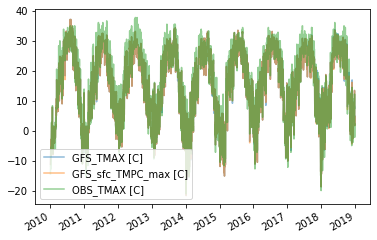

In [353]:
# Training data, x: TMAX from daily_gfs (in deg C)
GFS_TMAX_train = TMAX_ALL['GFS_TMAX']['2010-01-02':'2018-12-31']
print(GFS_TMAX_train)
GFS_TMAX_train.plot(alpha = 0.5, label = 'GFS_TMAX [C]');

# Training data, x: daily TMAX from sfc_gfs (in deg C)
GFS_sfc_TMPC_max_train = TMAX_ALL['GFS_sfc_TMPC_daily_max']['2010-01-02':'2018-12-31']
print(GFS_sfc_TMPC_max_train)
GFS_sfc_TMPC_max_train.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_max [C]');

# Training data, y: daily_obs (in deg C)
OBS_TMAX_train = TMAX_ALL['OBS_TMAX']['2010-01-02':'2018-12-31']
print(OBS_TMAX_train)
OBS_TMAX_train.plot(alpha = 0.5, label = 'OBS_TMAX [C]');
plt.legend(loc = 'best')

#### Validation data

2019-01-01     3.54
2019-01-02     1.54
2019-01-03     4.74
2019-01-04     5.24
2019-01-05     9.54
              ...  
2019-12-27    11.84
2019-12-28    13.94
2019-12-29    15.94
2019-12-30     7.24
2019-12-31    -0.36
Name: GFS_TMAX, Length: 364, dtype: float64
2019-01-01     3.54
2019-01-02     1.34
2019-01-03     4.64
2019-01-04     5.14
2019-01-05     9.54
              ...  
2019-12-27    11.84
2019-12-28    13.84
2019-12-29    15.64
2019-12-30     9.34
2019-12-31    -0.36
Name: GFS_sfc_TMPC_daily_max, Length: 364, dtype: float64
2019-01-01     2.777778
2019-01-02     0.000000
2019-01-03     3.333333
2019-01-04     3.888889
2019-01-05    10.555556
                ...    
2019-12-27     6.111111
2019-12-28    13.333333
2019-12-29    15.000000
2019-12-30     3.333333
2019-12-31     0.555556
Name: OBS_TMAX, Length: 364, dtype: float64


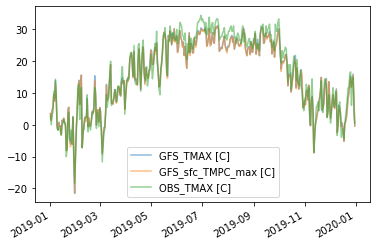

In [354]:
# Validation data, x: TMAX from daily_gfs (in deg C)
GFS_TMAX_pred = TMAX_ALL['GFS_TMAX']['2019-01-01':'2019-12-31']
print(GFS_TMAX_pred)
GFS_TMAX_pred.plot(alpha = 0.5, label = 'GFS_TMAX [C]');

# Validation data, x: daily TMAX from sfc_gfs (in deg C)
GFS_sfc_TMPC_max_pred = TMAX_ALL['GFS_sfc_TMPC_daily_max']['2019-01-01':'2019-12-31']
print(GFS_sfc_TMPC_max_pred)
GFS_sfc_TMPC_max_pred.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_max [C]');

# Validation data, y: daily_obs & Mask Missing Data (in deg C)
OBS_TMAX_pred = TMAX_ALL['OBS_TMAX']['2019-01-01':'2019-12-31']
print(OBS_TMAX_pred)
OBS_TMAX_pred.plot(alpha = 0.5, label = 'OBS_TMAX [C]');
plt.legend(loc = 'best')

## TMIN

### Prepare training and validation data for TMIN from GFS and observation

In [355]:
# (1) select consistent dates and units (2) concatenate columns (3) remove missing dates at once
OBS_TMIN = daily_obs['Min Hourly Temp (F)'].astype(float)['2010-01-02':'2019-12-31']
GFS_TMIN = daily_gfs_valid_time['TMIN']['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
GFS_sfc_TMPC_daily_min = sfc_gfs_raw['TMPC'].astype(float).resample('24H',base=6).min()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
OBS_TMIN = (OBS_TMIN-32)*5/9  # convert deg F to deg C

TMIN_concat = pd.concat([OBS_TMIN, GFS_TMIN, GFS_sfc_TMPC_daily_min], axis=1)
TMIN_concat.columns = ['OBS_TMIN', 'GFS_TMIN', 'GFS_sfc_TMPC_daily_min']
TMIN_ALL = TMIN_concat.dropna()
TMIN_ALL

,OBS_TMIN,GFS_TMIN,GFS_sfc_TMPC_daily_min
2010-01-02,-20.555556,-16.46,-16.06
2010-01-03,-21.111111,-15.96,-16.46
2010-01-04,-18.888889,-14.36,-14.36
2010-01-05,-18.333333,-12.86,-12.86
2010-01-06,-19.444444,-11.06,-11.66
...,...,...,...
2019-12-27,0.000000,3.84,4.54
2019-12-28,0.000000,3.54,3.64
2019-12-29,5.000000,9.34,10.44
2019-12-30,-0.555556,-1.66,-1.26


#### Training data

2010-01-02   -16.46
2010-01-03   -15.96
2010-01-04   -14.36
2010-01-05   -12.86
2010-01-06   -11.06
              ...  
2018-12-26     0.34
2018-12-27     5.04
2018-12-28     0.04
2018-12-29    -2.66
2018-12-30    -3.16
Name: GFS_TMIN, Length: 3225, dtype: float64
2010-01-02   -16.06
2010-01-03   -16.46
2010-01-04   -14.36
2010-01-05   -12.86
2010-01-06   -11.66
              ...  
2018-12-26     0.54
2018-12-27     5.04
2018-12-28     0.84
2018-12-29    -2.26
2018-12-30    -3.06
Name: GFS_sfc_TMPC_daily_min, Length: 3225, dtype: float64
2010-01-02   -20.555556
2010-01-03   -21.111111
2010-01-04   -18.888889
2010-01-05   -18.333333
2010-01-06   -19.444444
                ...    
2018-12-26    -4.444444
2018-12-27     3.888889
2018-12-28    -2.222222
2018-12-29    -5.000000
2018-12-30    -7.777778
Name: OBS_TMIN, Length: 3225, dtype: float64


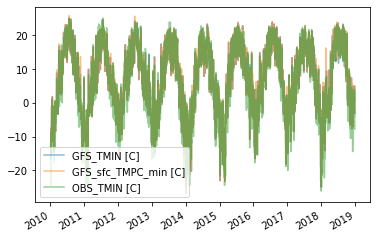

In [356]:
# Training data, x: TMIN from daily_gfs (in deg C)
GFS_TMIN_train = TMIN_ALL['GFS_TMIN']['2010-01-02':'2018-12-31']
print(GFS_TMIN_train)
GFS_TMIN_train.plot(alpha = 0.5, label = 'GFS_TMIN [C]');

# Training datad, x: daily TMIN from sfc_gfs (in deg C)
GFS_sfc_TMPC_min_train = TMIN_ALL['GFS_sfc_TMPC_daily_min']['2010-01-02':'2018-12-31']
print(GFS_sfc_TMPC_min_train)
GFS_sfc_TMPC_min_train.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_min [C]');

# Training data, y: daily_obs & Mask Missing Data (in deg C)
OBS_TMIN_train = TMIN_ALL['OBS_TMIN']['2010-01-02':'2018-12-31']
print(OBS_TMIN_train)
OBS_TMIN_train.plot(alpha = 0.5, label = 'OBS_TMIN [C]');
plt.legend(loc = 'best')

#### Validation data

2019-01-01   -0.86
2019-01-02   -1.16
2019-01-03   -2.26
2019-01-04   -0.06
2019-01-05    0.64
              ... 
2019-12-27    3.84
2019-12-28    3.54
2019-12-29    9.34
2019-12-30   -1.66
2019-12-31   -2.26
Name: GFS_TMIN, Length: 364, dtype: float64
2019-01-01    -0.16
2019-01-02    -0.86
2019-01-03    -2.26
2019-01-04    -0.16
2019-01-05     0.54
              ...  
2019-12-27     4.54
2019-12-28     3.64
2019-12-29    10.44
2019-12-30    -1.26
2019-12-31    -2.06
Name: GFS_sfc_TMPC_daily_min, Length: 364, dtype: float64
2019-01-01    0.000000
2019-01-02   -2.222222
2019-01-03   -3.333333
2019-01-04   -3.888889
2019-01-05   -1.111111
                ...   
2019-12-27    0.000000
2019-12-28    0.000000
2019-12-29    5.000000
2019-12-30   -0.555556
2019-12-31   -1.111111
Name: OBS_TMIN, Length: 364, dtype: float64


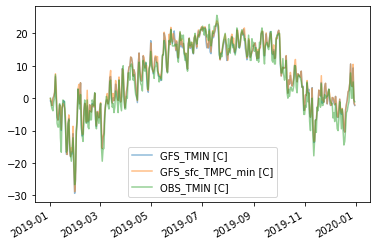

In [357]:
# Validation data, x: TMIN from daily_gfs (in deg C)
GFS_TMIN_pred = TMIN_ALL['GFS_TMIN']['2019-01-01':'2019-12-31']
print(GFS_TMIN_pred)
GFS_TMIN_pred.plot(alpha = 0.5, label = 'GFS_TMIN [C]');

# Validation data, x: daily TMIN from sfc_gfs (in deg C)
GFS_sfc_TMPC_min_pred = TMIN_ALL['GFS_sfc_TMPC_daily_min']['2019-01-01':'2019-12-31']
print(GFS_sfc_TMPC_min_pred)
GFS_sfc_TMPC_min_pred.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_min [C]');

# Validation data, y: daily_obs & Mask Missing Data (in deg C)
OBS_TMIN_pred = TMIN_ALL['OBS_TMIN']['2019-01-01':'2019-12-31']
print(OBS_TMIN_pred)
OBS_TMIN_pred.plot(alpha = 0.5, label = 'OBS_TMIN [C]');
plt.legend(loc = 'best')

## Max Wind (WMAX)

### Prepare training and validation data for WMAX from GFS and observation

In [358]:
# (1) select consistent dates and units (2) concatenate columns (3) remove missing dates at once
OBS_WMAX = daily_obs['Max Wind Speed (mph)'].astype(float)['2010-01-02':'2019-12-31']
GFS_WMAX = daily_gfs_valid_time['WMAX']['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
GFS_sfc_WPSD_daily_max = sfc_gfs_raw['WSPD'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
OBS_WMAX = OBS_WMAX*0.44704  # converted from mph to m/s

WMAX_concat = pd.concat([OBS_WMAX, GFS_WMAX, GFS_sfc_WPSD_daily_max], axis=1)
WMAX_concat.columns = ['OBS_WMAX', 'GFS_WMAX', 'GFS_sfc_WSPD_daily_max']
WMAX_ALL = WMAX_concat.dropna()
WMAX_ALL

,OBS_WMAX,GFS_WMAX,GFS_sfc_WSPD_daily_max
2010-01-02,6.70560,7.323933,7.323933
2010-01-03,4.91744,4.687217,4.687217
2010-01-04,8.94080,5.941380,5.941380
2010-01-05,7.15264,5.685068,5.685068
2010-01-06,3.57632,3.794733,3.794733
...,...,...,...
2019-12-27,6.70560,4.301163,3.687818
2019-12-28,10.28192,8.819297,7.823043
2019-12-29,10.28192,9.701546,8.796590
2019-12-30,11.62304,11.111256,11.111256


#### Training data

2010-01-02     7.323933
2010-01-03     4.687217
2010-01-04     5.941380
2010-01-05     5.685068
2010-01-06     3.794733
                ...    
2018-12-26     7.360027
2018-12-27    10.288343
2018-12-28     7.990620
2018-12-29     5.001000
2018-12-30     6.580274
Name: GFS_WMAX, Length: 3227, dtype: float64
2010-01-02     7.323933
2010-01-03     4.687217
2010-01-04     5.941380
2010-01-05     5.685068
2010-01-06     3.794733
                ...    
2018-12-26     6.161169
2018-12-27    10.288343
2018-12-28     7.963040
2018-12-29     5.186521
2018-12-30     6.440497
Name: GFS_sfc_WSPD_daily_max, Length: 3227, dtype: float64
2010-01-02     6.70560
2010-01-03     4.91744
2010-01-04     8.94080
2010-01-05     7.15264
2010-01-06     3.57632
                ...   
2018-12-26     6.70560
2018-12-27    14.75232
2018-12-28    10.28192
2018-12-29     7.15264
2018-12-30     9.38784
Name: OBS_WMAX, Length: 3227, dtype: float64


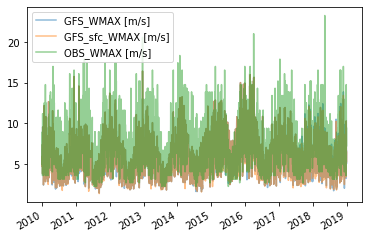

In [359]:
# Training data, x: WMAX from daily_gfs (in m/s)
GFS_WMAX_train = WMAX_ALL['GFS_WMAX']['2010-01-02':'2018-12-31']
print(GFS_WMAX_train)
GFS_WMAX_train.plot(alpha = 0.5, label = 'GFS_WMAX [m/s]');

# Training data, x: daily max WSPD from sfc_gfs (in m/s)
GFS_sfc_WMAX_train = WMAX_ALL['GFS_sfc_WSPD_daily_max']['2010-01-02':'2018-12-31']
print(GFS_sfc_WMAX_train)
GFS_sfc_WMAX_train.plot(alpha = 0.5, label = 'GFS_sfc_WMAX [m/s]');

# # Training data, y: daily_obs & Mask Missing Data (in m/s)
OBS_WMAX_train = WMAX_ALL['OBS_WMAX']['2010-01-02':'2018-12-31']
print(OBS_WMAX_train)
OBS_WMAX_train.plot(alpha = 0.5, label = 'OBS_WMAX [m/s]');
plt.legend(loc = 'best')

#### Validation data

2019-01-01     5.423099
2019-01-02     5.859181
2019-01-03     4.609772
2019-01-04     3.667424
2019-01-05     4.701064
                ...    
2019-12-27     4.301163
2019-12-28     8.819297
2019-12-29     9.701546
2019-12-30    11.111256
2019-12-31     8.769265
Name: GFS_WMAX, Length: 363, dtype: float64
2019-01-01     5.675385
2019-01-02     5.859181
2019-01-03     4.785394
2019-01-04     3.324154
2019-01-05     4.701064
                ...    
2019-12-27     3.687818
2019-12-28     7.823043
2019-12-29     8.796590
2019-12-30    11.111256
2019-12-31     8.928606
Name: GFS_sfc_WSPD_daily_max, Length: 363, dtype: float64
2019-01-01     6.25856
2019-01-02     7.59968
2019-01-03     6.25856
2019-01-04     4.91744
2019-01-05     6.25856
                ...   
2019-12-27     6.70560
2019-12-28    10.28192
2019-12-29    10.28192
2019-12-30    11.62304
2019-12-31    12.96416
Name: OBS_WMAX, Length: 363, dtype: float64


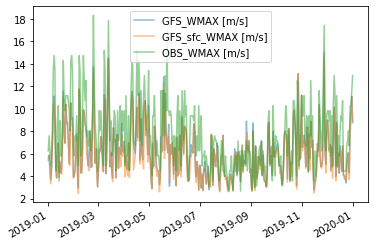

In [360]:
# Validation data, x: WMAX from daily_gfs (in m/s)
GFS_WMAX_pred = WMAX_ALL['GFS_WMAX']['2019-01-01':'2019-12-31']
print(GFS_WMAX_pred)
GFS_WMAX_pred.plot(alpha = 0.5, label = 'GFS_WMAX [m/s]');

# Validation data, x: daily max WSPD from sfc_gfs (in m/s)
GFS_sfc_WMAX_pred = WMAX_ALL['GFS_sfc_WSPD_daily_max']['2019-01-01':'2019-12-31']
print(GFS_sfc_WMAX_pred)
GFS_sfc_WMAX_pred.plot(alpha = 0.5, label = 'GFS_sfc_WMAX [m/s]');

# Validation data, y: daily_obs & Mask Missing Data (in m/s)
OBS_WMAX_pred = WMAX_ALL['OBS_WMAX']['2019-01-01':'2019-12-31']
print(OBS_WMAX_pred)
OBS_WMAX_pred.plot(alpha = 0.5, label = 'OBS_WMAX [m/s]');
plt.legend(loc = 'best')

## Precipitation (PRCP)

### Prepare training and validation data for PRECIP from GFS and observation

In [0]:
# Treat trace precip as 0:
daily_gfs_raw['RTOT'][daily_gfs_raw['RTOT'] < 0] = 0 # Takes care of trace precip
sfc_gfs_raw['PRCP'][sfc_gfs_raw['PRCP'] < 0] = 0

In [362]:
# For linear regression model
# (1) select consistent dates and units (2) concatenate columns (3) remove missing dates at once
OBS_PRCP = daily_obs['Total Precip from Hourly (mm)'].astype(float)['2010-01-02':'2019-12-31']
GFS_PRCP = daily_gfs_valid_time['RTOT']['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
GFS_sfc_PRCP_daily_total = sfc_gfs_raw['PRCP'].astype(float).resample('24H',base=6).sum()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
GFS_sfc_PRCP_daily_max = sfc_gfs_raw['PRCP'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
HCLD_sfc_mean = sfc_gfs_raw['HCLD'].astype(float).resample('24H',base=6).mean()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
VWND_700_max = prof_gfs_raw['VWND_700'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
VWND_500_max = prof_gfs_raw['VWND_500'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
UWND_500_mean = prof_gfs_raw['UWND_500'].astype(float).resample('24H',base=6).mean()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()

PRCP_concat = pd.concat([OBS_PRCP, GFS_PRCP, GFS_sfc_PRCP_daily_total, GFS_sfc_PRCP_daily_max, HCLD_sfc_mean, VWND_700_max, VWND_500_max, UWND_500_mean], axis=1)
PRCP_concat.columns = ['OBS_PRCP', 'GFS_PRCP', 'GFS_sfc_PRCP_daily_total', 'GFS_sfc_PRCP_daily_max', 'HCLD_sfc_mean', 'VWND_700_max', 'VWND_500_max', 'UWND_500_mean']  # try the variables used by Group H
PRCP_ALL_LR = PRCP_concat.dropna()
PRCP_ALL_LR

,OBS_PRCP,GFS_PRCP,GFS_sfc_PRCP_daily_total,GFS_sfc_PRCP_daily_max,HCLD_sfc_mean,VWND_700_max,VWND_500_max,UWND_500_mean
2010-01-02,0.0,0.05,0.05,0.04,0.000000,-29.544206,-44.745111,50.147040
2010-01-03,0.0,0.00,0.00,0.00,7.375000,-17.009916,-24.867367,35.678307
2010-01-04,0.0,0.06,0.03,0.03,29.444444,-17.739194,-14.963725,8.720827
2010-01-05,0.0,0.17,0.20,0.03,37.555556,-16.146781,-13.743143,11.631287
2010-01-06,1.5,0.77,0.11,0.05,25.555556,2.739087,-3.375251,28.831135
...,...,...,...,...,...,...,...,...
2019-12-27,0.0,0.00,0.08,0.08,69.333333,17.869363,28.590933,50.006554
2019-12-28,2.8,2.73,1.19,0.53,77.000000,39.055512,43.724712,32.451986
2019-12-29,4.3,11.58,12.34,9.70,91.444444,47.566961,80.606813,28.750351
2019-12-30,0.6,2.57,3.34,2.08,7.666667,38.705449,42.353354,42.722259


In [363]:
# For random forest regression model
# (1) select consistent dates and units (2) concatenate columns (3) remove missing dates at once
OBS_PRCP = daily_obs['Total Precip from Hourly (mm)'].astype(float)['2010-01-02':'2019-12-31']
GFS_PRCP = daily_gfs_valid_time['RTOT']['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
GFS_sfc_PRCP_daily_max = sfc_gfs_raw['PRCP'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
GFS_sfc_PRCP_daily_mean = sfc_gfs_raw['PRCP'].astype(float).resample('24H',base=6).mean()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
DWPC_700_min = prof_gfs_raw['DWPC_700'].astype(float).resample('24H',base=6).min()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
DWPC_500_max = prof_gfs_raw['DWPC_500'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
VWND_500_max = prof_gfs_raw['VWND_500'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()

PRCP_concat = pd.concat([OBS_PRCP, GFS_PRCP, GFS_sfc_PRCP_daily_max, GFS_sfc_PRCP_daily_mean, DWPC_700_min, DWPC_500_max, VWND_500_max], axis=1)
PRCP_concat.columns = ['OBS_PRCP', 'GFS_PRCP', 'GFS_sfc_PRCP_daily_max', 'GFS_sfc_PRCP_daily_mean', 'DWPC_700_min', 'DWPC_500_max', 'VWND_500_max']  # try the variables used by Group H
PRCP_ALL_RF = PRCP_concat.dropna()
PRCP_ALL_RF

,OBS_PRCP,GFS_PRCP,GFS_sfc_PRCP_daily_max,GFS_sfc_PRCP_daily_mean,DWPC_700_min,DWPC_500_max,VWND_500_max
2010-01-02,0.0,0.05,0.04,0.006250,-43.782516,-39.079549,-44.745111
2010-01-03,0.0,0.00,0.00,0.000000,-54.588994,-34.758090,-24.867367
2010-01-04,0.0,0.06,0.03,0.003333,-33.074543,-32.989068,-14.963725
2010-01-05,0.0,0.17,0.03,0.022222,-32.457111,-32.362712,-13.743143
2010-01-06,1.5,0.77,0.05,0.012222,-35.033016,-28.285840,-3.375251
...,...,...,...,...,...,...,...
2019-12-27,0.0,0.00,0.08,0.008889,-41.140000,-30.988810,28.590933
2019-12-28,2.8,2.73,0.53,0.132222,-9.754482,-16.800948,43.724712
2019-12-29,4.3,11.58,9.70,1.371111,-22.392055,-14.440435,80.606813
2019-12-30,0.6,2.57,2.08,0.371111,-22.540655,-27.982653,42.353354


#### Training data

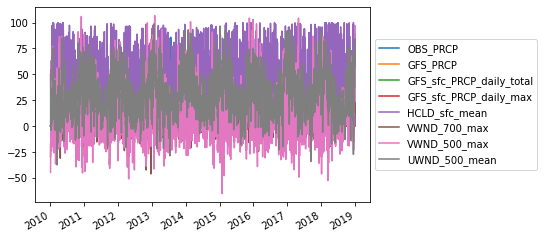

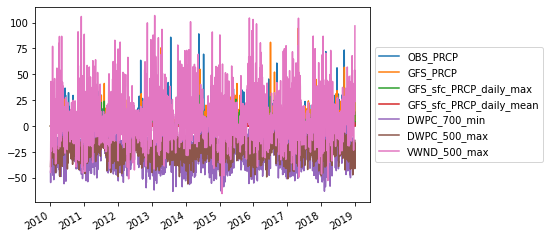

In [364]:
# # Training data, x: RTOT from daily_gfs (in mm)
# GFS_PRCP_train = PRCP_ALL['GFS_PRCP']['2010-01-02':'2018-12-31']
# print(GFS_PRCP_train)
# GFS_PRCP_train.plot(alpha = 0.5, label = 'GFS_PRCP [mm]');

# # Training data, x: daily total PRCP from sfc_gfs (in mm)
# GFS_sfc_PRCP_train = PRCP_ALL['GFS_sfc_PRCP_daily_total']['2010-01-02':'2018-12-31']
# print(GFS_sfc_PRCP_train)
# GFS_sfc_PRCP_train.plot(alpha = 0.5, label = 'GFS_sfc_PRCP [mm]');

# # Training data, y: daily_obs & Mask Missing Data (in mm)
# OBS_PRCP_train = PRCP_ALL['OBS_PRCP']['2010-01-02':'2018-12-31']
# print(OBS_PRCP_train)
# OBS_PRCP_train.plot(alpha = 0.5, label = 'OBS_PRCP [mm]');
# plt.legend(loc = 'best')

PRCP_ALL_LR['2010-01-02':'2018-12-31'].plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

PRCP_ALL_RF['2010-01-02':'2018-12-31'].plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Validation data

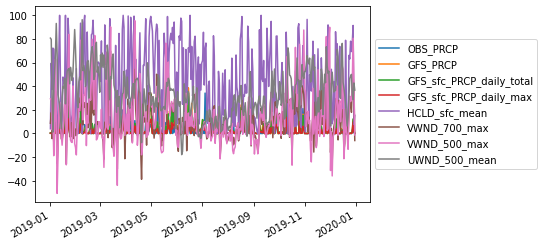

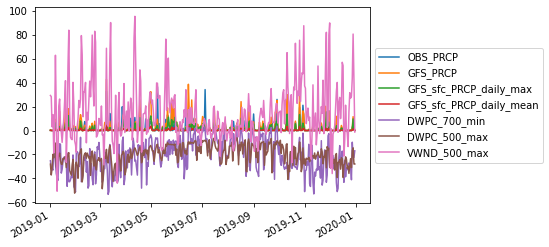

In [365]:
# # Validation data, x: RTOT from daily_gfs (in mm)
# GFS_PRCP_pred = PRCP_ALL['GFS_PRCP']['2019-01-01':'2019-12-31']
# print(GFS_PRCP_pred)
# GFS_PRCP_pred.plot(alpha = 0.5, label = 'GFS_PRCP [mm]');

# # Validation data, x: daily total PRCP from sfc_gfs (in mm)
# GFS_sfc_PRCP_pred = PRCP_ALL['GFS_sfc_PRCP_daily_total']['2019-01-01':'2019-12-31']
# print(GFS_sfc_PRCP_pred)
# GFS_sfc_PRCP_pred.plot(alpha = 0.5, label = 'GFS_sfc_PRCP [mm]');

# # Validation data, y: daily_obs & Mask Missing Data (in mm)
# OBS_PRCP_pred = PRCP_ALL['OBS_PRCP']['2019-01-01':'2019-12-31']
# print(OBS_PRCP_pred)
# OBS_PRCP_pred.plot(alpha = 0.5, label = 'OBS_PRCP [mm]');
# plt.legend(loc = 'best')

PRCP_ALL_LR['2019-01-01':'2019-12-31'].plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

PRCP_ALL_RF['2019-01-01':'2019-12-31'].plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Linear regression model


## TMAX

### Training

Model slope:     [0.81910761 0.25291388]
RMS of TMAX LR training:  2.243860346972388


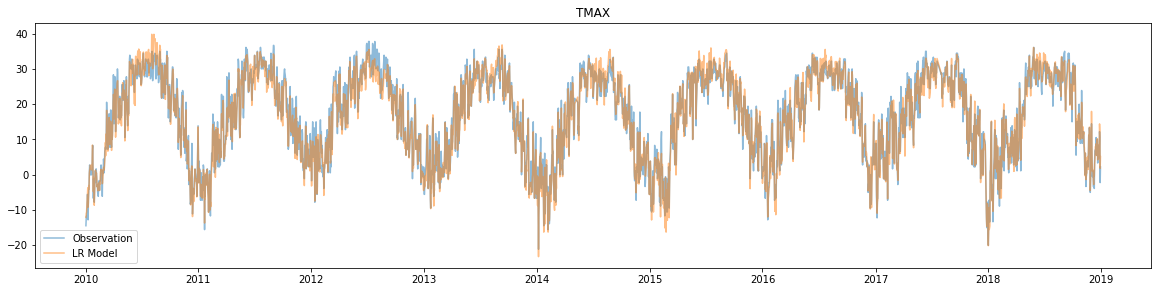

In [366]:
# Training
X = np.column_stack((GFS_TMAX_train.values, GFS_sfc_TMPC_max_train.values))  # GFS model daily and sfc max TMPC
y = OBS_TMAX_train.values  # Observation

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

rms_TMAX_LR_train = sqrt(mean_squared_error(y, y_model))
print('RMS of TMAX LR training: ', rms_TMAX_LR_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_TMAX_train.index, X, alpha=0.5)
plt.plot(OBS_TMAX_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('TMAX')
plt.legend()
plt.show()

### Validation

RMS of TMAX LR:  2.0210979787895416


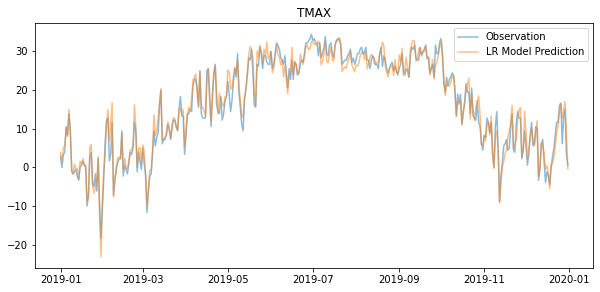

In [367]:
# Validation
X_predict = np.column_stack((GFS_TMAX_pred.values, GFS_sfc_TMPC_max_pred.values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = OBS_TMAX_pred.values  # Observation

rms_TMAX_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of TMAX LR: ', rms_TMAX_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMAX_pred.index, X, alpha=0.5)
plt.plot(OBS_TMAX_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('TMAX')
plt.legend()
plt.show()

## TMIN

### Training

Model slope:     [0.87602057 0.13003458]
RMS of TMIN LR training:  2.146277443997052


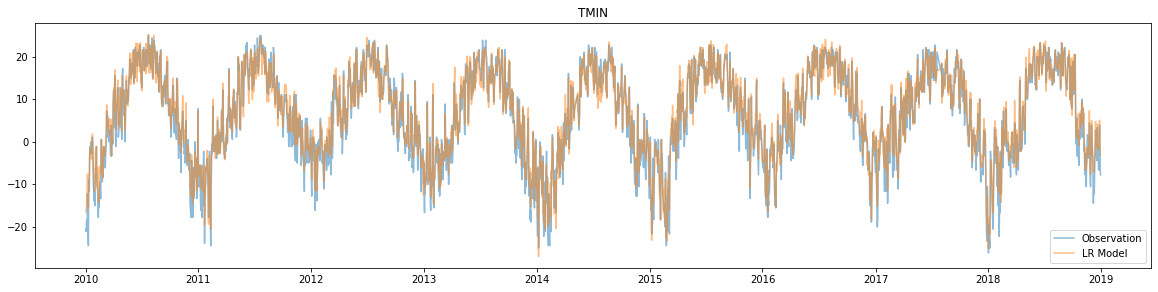

In [368]:
# Training
X = np.column_stack((GFS_TMIN_train.values, GFS_sfc_TMPC_min_train.values))  # GFS model daily and sfc min TMPC
y = OBS_TMIN_train.values  # Observation

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)

rms_TMIN_LR_train = sqrt(mean_squared_error(y, y_model))
print('RMS of TMIN LR training: ', rms_TMIN_LR_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_TMIN_train.index, X, alpha=0.5)
plt.plot(OBS_TMIN_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('TMIN')
plt.legend()
plt.show()

### Validation

RMS of TMIN LR:  2.1469875505608638


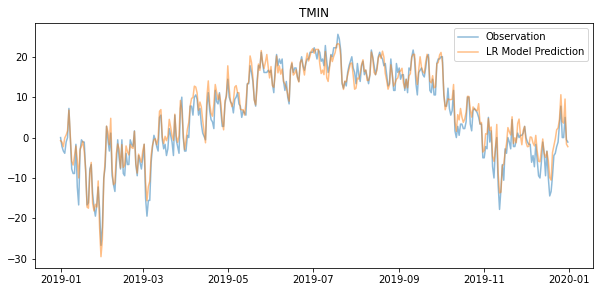

In [369]:
# Validation
X_predict = np.column_stack((GFS_TMIN_pred.values, GFS_sfc_TMPC_min_pred.values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = OBS_TMIN_pred.values  # Observation

rms_TMIN_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of TMIN LR: ', rms_TMIN_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMIN_pred.index, X, alpha=0.5)
plt.plot(OBS_TMIN_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('TMIN')
plt.legend()
plt.show()

## Max Wind

### Training

Model slope:     [0.89309483 0.39048531]
RMS of WMAX LR:  1.7926311454029


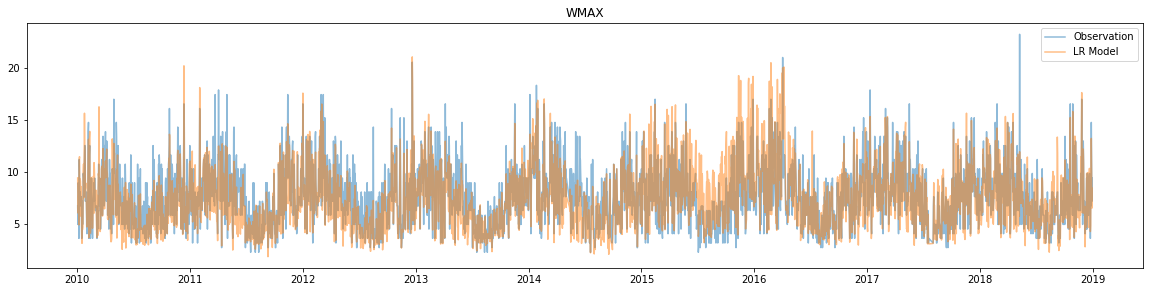

In [370]:
# Training
X = np.column_stack((GFS_WMAX_train.values, GFS_sfc_WMAX_train.values))  # GFS model daily and sfc
y = OBS_WMAX_train.values  # Observation

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

rms_WMAX_LR_train = sqrt(mean_squared_error(y, y_model))
print('RMS of WMAX LR: ', rms_WMAX_LR_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_WMAX_train.index, X, alpha=0.5)
plt.plot(OBS_WMAX_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('WMAX')
plt.legend()
plt.show()

### Validation

RMS of WMAX LR:  1.6398612596788842


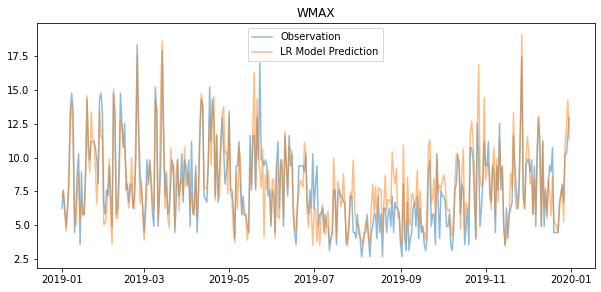

In [371]:
# Validation
X_predict = np.column_stack((GFS_WMAX_pred.values, GFS_sfc_WMAX_pred.values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = OBS_WMAX_pred.values  # Observation

rms_WMAX_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of WMAX LR: ', rms_WMAX_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_WMAX_pred.index, X, alpha=0.5)
plt.plot(OBS_WMAX_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('WMAX')
plt.legend()
plt.show()

## Precipitation

### Training

Model slope:     [ 0.34207641  0.29418629 -0.41502235  0.01582773  0.01798811  0.00992646
 -0.00133561]
RMS of PRCP LR:  5.242515979860484


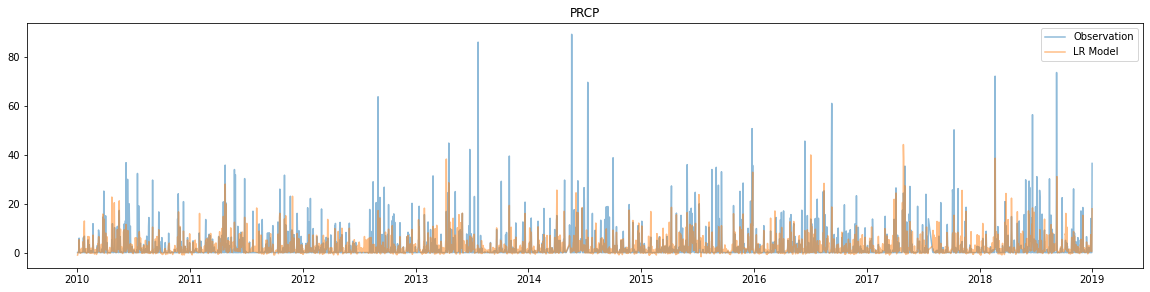

In [372]:
# Training
# X = np.column_stack((GFS_PRCP_train.values, GFS_sfc_PRCP_train.values))  # GFS model daily and sfc
X = np.row_stack((PRCP_ALL_LR['2010-01-02':'2018-12-31'].iloc[:,1:].values))
y = OBS_PRCP_train.values  # Observation

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)

rms_PRCP_LR_train = sqrt(mean_squared_error(y, y_model))
print('RMS of PRCP LR: ', rms_PRCP_LR_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_PRCP_train.index, X, alpha=0.5)
plt.plot(OBS_PRCP_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('PRCP')
plt.legend()
plt.show()

### Validation

RMS of PRCP LR:  3.824535221483504


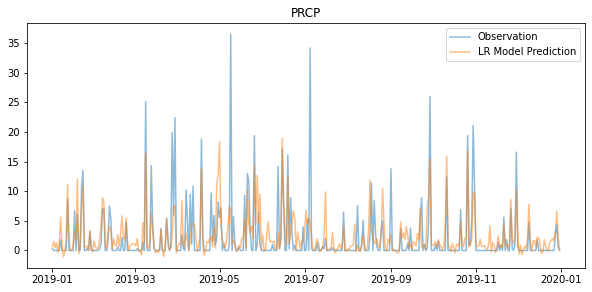

In [373]:
# Validation
# X_predict = np.column_stack((GFS_PRCP_pred.values, GFS_sfc_PRCP_pred.values))
X_predict = np.row_stack((PRCP_ALL_LR['2019-01-01':'2019-12-31'].iloc[:,1:].values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = OBS_PRCP_pred.values  # Observation

rms_PRCP_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of PRCP LR: ', rms_PRCP_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_PRCP_pred.index, X, alpha=0.5)
plt.plot(OBS_PRCP_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('PRCP')
plt.legend()
plt.show()

In [374]:
RMS_LR = [rms_TMAX_LR, rms_TMIN_LR, rms_WMAX_LR, rms_PRCP_LR]
RMS_LR

[2.0210979787895416, 2.1469875505608638, 1.6398612596788842, 3.824535221483504]

# Random forest regression model

## TMAX

### Training

RMS of TMAX RF training:  1.8764895366263286


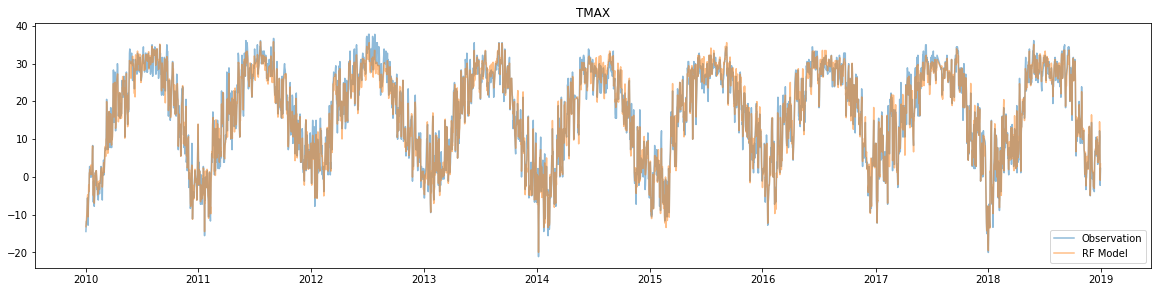

In [375]:
# Training
X = np.column_stack((GFS_TMAX_train.values, GFS_sfc_TMPC_max_train.values))  # GFS model daily and sfc max TMPC
y = OBS_TMAX_train.values  # Observation

forest = RandomForestRegressor(n_estimators = 225) #, max_depth = 500)
forest.fit(X, y)

# Calculate model result for the training period and visualize it
y_model = forest.predict(X)

rms_TMAX_RF_train = sqrt(mean_squared_error(y, y_model))
print('RMS of TMAX RF training: ', rms_TMAX_RF_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_TMAX_train.index, X, alpha=0.5)
plt.plot(OBS_TMAX_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_train.index, y_model, alpha=0.5, label='RF Model')
plt.title('TMAX')
plt.legend()
plt.show()

### Validation

RMS of TMAX RF:  2.227755626559382


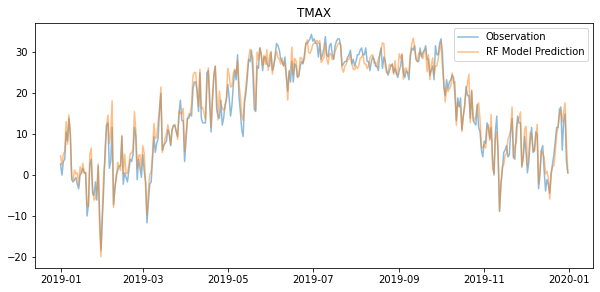

In [376]:
# Validation
X_predict = np.column_stack((GFS_TMAX_pred.values, GFS_sfc_TMPC_max_pred.values))
y_predict = forest.predict(X_predict)  # random forest regression model prediction
y_true = OBS_TMAX_pred.values  # Observation

rms_TMAX_RF = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of TMAX RF: ', rms_TMAX_RF)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMAX_pred.index, X, alpha=0.5)
plt.plot(OBS_TMAX_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_pred.index, y_predict, alpha=0.5, label='RF Model Prediction')
plt.title('TMAX')
plt.legend()
plt.show()

## TMIN

### Training

RMS of TMIN RF training:  1.3465165497715366


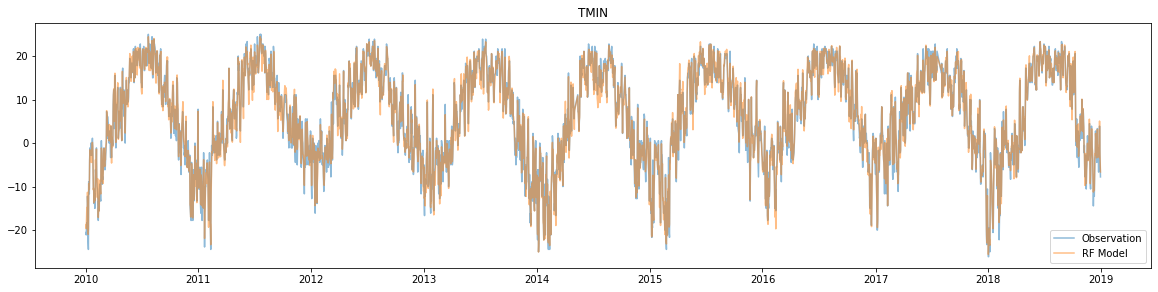

In [377]:
# Training
X = np.column_stack((GFS_TMIN_train.values, GFS_sfc_TMPC_min_train.values))  # GFS model daily and sfc min TMPC
y = OBS_TMIN_train.values  # Observation

forest = RandomForestRegressor(250)
forest.fit(X, y)

# Calculate model result for the training period and visualize it
y_model = forest.predict(X)

rms_TMIN_RF_train = sqrt(mean_squared_error(y, y_model))
print('RMS of TMIN RF training: ', rms_TMIN_RF_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_TMIN_train.index, X, alpha=0.5)
plt.plot(OBS_TMIN_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_train.index, y_model, alpha=0.5, label='RF Model')
plt.title('TMIN')
plt.legend()
plt.show()

### Validation

RMS of TMIN RF:  1.9745839110274443


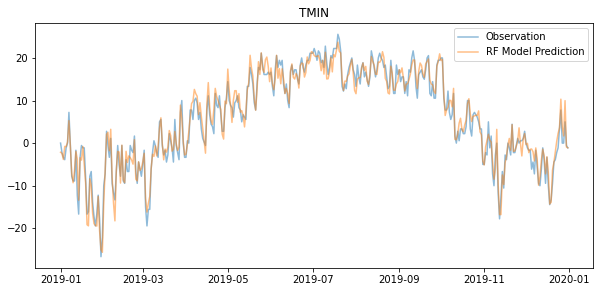

In [378]:
# Validation
X_predict = np.column_stack((GFS_TMIN_pred.values, GFS_sfc_TMPC_min_pred.values))
y_predict = forest.predict(X_predict)  # random forest regression model prediction
y_true = OBS_TMIN_pred.values  # Observation

rms_TMIN_RF = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of TMIN RF: ', rms_TMIN_RF)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMIN_pred.index, X, alpha=0.5)
plt.plot(OBS_TMIN_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_pred.index, y_predict, alpha=0.5, label='RF Model Prediction')
plt.title('TMIN')
plt.legend()
plt.show()

## Max Wind

### Training

RMS of WMAX RF training:  0.9822188232509692


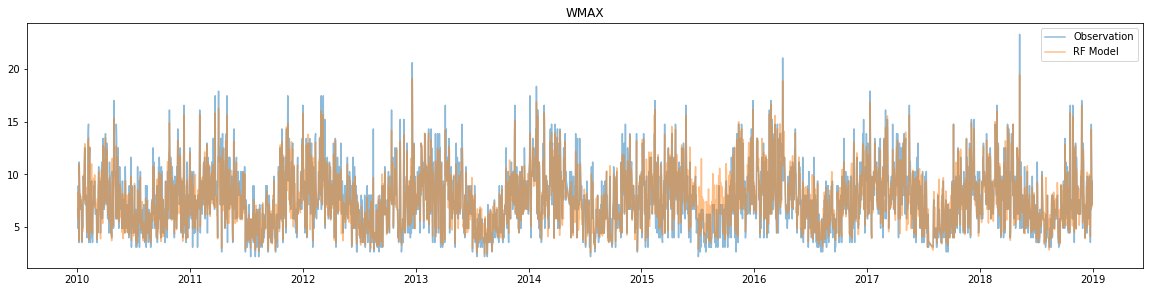

In [379]:
# Training
X = np.column_stack((GFS_WMAX_train.values, GFS_sfc_WMAX_train.values))  # GFS model daily and sfc
y = OBS_WMAX_train.values  # Observation

forest = RandomForestRegressor(100)
forest.fit(X, y)

# Calculate model result for the training period and visualize it
y_model = forest.predict(X)

rms_WMAX_RF_train = sqrt(mean_squared_error(y, y_model))
print('RMS of WMAX RF training: ', rms_WMAX_RF_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_WMAX_train.index, X, alpha=0.5)
plt.plot(OBS_WMAX_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_train.index, y_model, alpha=0.5, label='RF Model')
plt.title('WMAX')
plt.legend()
plt.show()

### Validation

RMS of WMAX RF:  1.8259256649605522


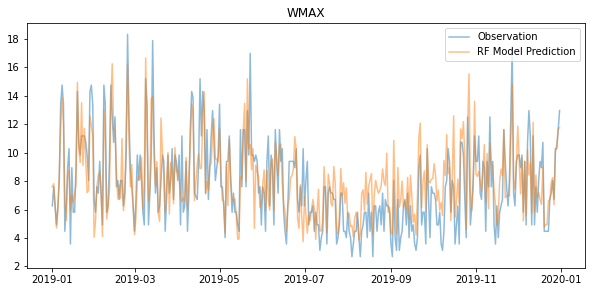

In [380]:
# Validation
X_predict = np.column_stack((GFS_WMAX_pred.values, GFS_sfc_WMAX_pred.values))
y_predict = forest.predict(X_predict)  # random forest regression model prediction
y_true = OBS_WMAX_pred.values  # Observation

rms_WMAX_RF = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of WMAX RF: ', rms_WMAX_RF)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_WMAX_pred.index, X, alpha=0.5)
plt.plot(OBS_WMAX_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_pred.index, y_predict, alpha=0.5, label='RF Model Prediction')
plt.title('WMAX')
plt.legend()
plt.show()

## Precipitation

### Training

RMS of PRCP RF training:  1.9351158102588033


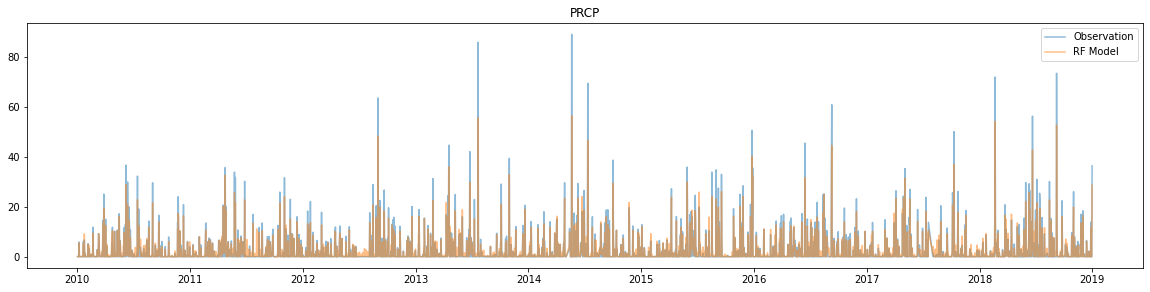

In [387]:
# Training
# X = np.column_stack((GFS_PRCP_train.values, GFS_sfc_PRCP_train.values))  # GFS model daily and sfc
X = np.row_stack((PRCP_ALL_RF['2010-01-02':'2018-12-31'].iloc[:,1:].values))
y = OBS_PRCP_train.values  # Observation

forest = RandomForestRegressor(n_estimators = 1000, max_features = 1)
forest.fit(X, y)

# Calculate model result for the training period and visualize it
y_model = forest.predict(X)

rms_PRCP_RF_train = sqrt(mean_squared_error(y, y_model))
print('RMS of PRCP RF training: ', rms_PRCP_RF_train)

plt.figure(figsize=(20, 4.5))
# plt.plot(OBS_PRCP_train.index, X, alpha=0.5)
plt.plot(OBS_PRCP_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_train.index, y_model, alpha=0.5, label='RF Model')
plt.title('PRCP')
plt.legend()
plt.show()

### Validation

RMS of PRCP RF:  4.042574841213606


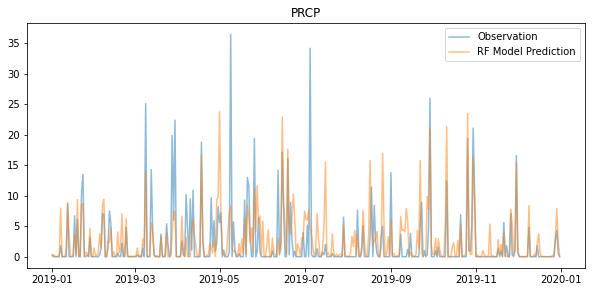

In [388]:
# Validation
# X_predict = np.column_stack((GFS_PRCP_pred.values, GFS_sfc_PRCP_pred.values))
X_predict = np.row_stack((PRCP_ALL_RF['2019-01-01':'2019-12-31'].iloc[:,1:].values))
y_predict = forest.predict(X_predict)  # random forest regression model prediction
y_true = OBS_PRCP_pred.values  # Observation

rms_PRCP_RF = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of PRCP RF: ', rms_PRCP_RF)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_PRCP_pred.index, X, alpha=0.5)
plt.plot(OBS_PRCP_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_pred.index, y_predict, alpha=0.5, label='RF Model Prediction')
plt.title('PRCP')
plt.legend()
plt.show()

In [389]:
RMS_RF = [rms_TMAX_RF, rms_TMIN_RF, rms_WMAX_RF, rms_PRCP_RF]
RMS_RF

[2.227755626559382, 1.9745839110274443, 1.8259256649605522, 4.042574841213606]

In [390]:
# Summary for both linear regression model and random forest regression model
print('RMS of LR: ', RMS_LR)
print('RMS of RF: ', RMS_RF)

RMS of LR:  [2.0210979787895416, 2.1469875505608638, 1.6398612596788842, 3.824535221483504]
RMS of RF:  [2.227755626559382, 1.9745839110274443, 1.8259256649605522, 4.042574841213606]
